In [1]:
from __future__ import annotations
%matplotlib inline

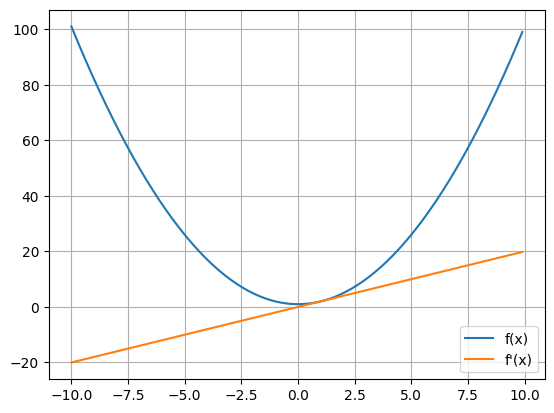

In [2]:
# What is a derivative?
# Let's start with a simple function and manual derivative calculation (based on calculus).
import numpy as np
import matplotlib.pyplot as plt

_input = np.arange(-10, 10, 0.1)

def f(x):
    return x**2 + 1

def derivative_f(x):
    return 2 * x

# make plot a grid
plt.grid()
plt.plot(_input, f(_input), label='f(x)')
plt.plot(_input, derivative_f(_input), label='f\'(x)')
plt.legend()

# intuition:
# negative derivative means that the function is decreasing
# positive derivative means that the function is increasing

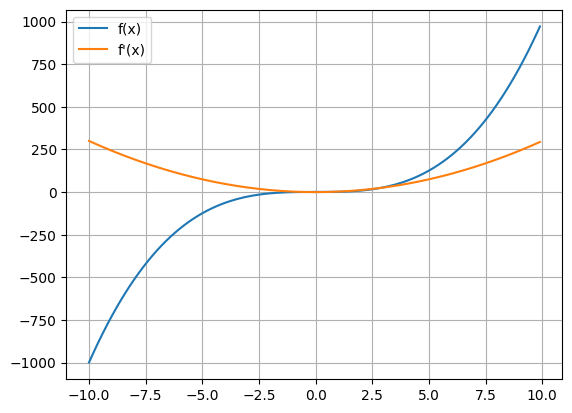

In [3]:
# let's test it on another monotonic function (increasing function)
import numpy as np
import matplotlib.pyplot as plt

_input = np.arange(-10, 10, 0.1)

def f(x):
    return x**3 + 1

def derivative_f(x):
    return 3 * (x**2)

# make plot a grid
plt.grid()
plt.plot(_input, f(_input), label='f(x)')
plt.plot(_input, derivative_f(_input), label='f\'(x)')
plt.legend()

# next intuition:
# bigger derivative means that the function is increasing faster
# smaller derivative means that the function is increasing slower

In [4]:
# let's look at official definition of derivative
# https://en.wikipedia.org/wiki/Derivative

# important part is that there is `f(x + h) - f(x)` -> we approach the point `x` from the right side
# it is also useful only for specific point `x` (not for all points)

print(f"{f(-5)=}")
print(f"{derivative_f(-5)=}")

print("\n\nManual:")
h = 0.0001 # small POSITIVE step size -> gradient is telling us about the slope on right side of the point
x = -5
gradient = (f(x + h) - f(x)) / h
gradient # should be 75

f(-5)=-124
derivative_f(-5)=75


Manual:


74.99850000982633

In [5]:
# https://en.wikipedia.org/wiki/Derivative (gradient is a vector of partial derivatives)
# https://en.wikipedia.org/wiki/Gradient_descent - fog parallel
h = 0.0001 # small POSITIVE step size -> gradient is telling us about the slope on right side of the point
x = 5
gradient = (f(x + h) - f(x)) / h
gradient # should be 75

75.00150000979033

In [6]:
# https://www.geogebra.org/m/TymMwUtc

# (f(x + h) - f(x)) is basically giving two points on the function [x, f(x)] and [x + h, f(x + h)]
# and then we can calculate the slope of the line between these two points

In [7]:
# we will use some of the derivative rules - https://www.mathsisfun.com/calculus/derivatives-rules.html
# it is basically just a set of rules how to calculate the derivative of a function

# the most important rule is the chain rule - https://en.wikipedia.org/wiki/Chain_rule
# If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man.

# Mathematical representation of unit

In [8]:
# To achieve similar behavior as with Pytorch we need to have a class which:

# backward pass
# zero_grad
# forward pass

In [9]:
# just a helper function to display the tree-like structure of the computational graph

def display_tree_visualization_of_node(node: Value, prefix="", is_last=True):
    """Display a tree-like visualization of the computational graph."""
    if prefix == "":  # Root node
        print(f"Result: {node.data}")
        print()
        connector = ""
    else:
        connector = "└── " if is_last else "├── "

    print(f"{prefix}{connector}{node.data:<4.2f} ({node._op}, grad:{node.grad:.2f}, id:{node._id})")

    # Set the prefix for the next level
    child_prefix = prefix + ("    " if is_last else "│   ")

    # Process children
    children = list(node._children)
    for i, child in enumerate(children):
        is_last_child = (i == len(children) - 1)
        display_tree_visualization_of_node(child, child_prefix, is_last_child)

In [10]:
# backward pass - reference to children nodes
# zero_grad - gradient of current node (settable to 0)
# forward pass - data of current node

In [11]:
# forward pass

class Value:
    def __init__(self, data, _children=(), *, op='leaf', backward=lambda: None):
        self.data: float = data
        self._children: set = _children
        self._op: str = op
        self.grad: float = 0.0
        self._id: int = id(self)  # Unique identifier for the node, useful for debugging

        self.backward: callable = backward

    def __repr__(self):
        return f"Value(data={self.data}, op='{self._op}', id={self._id})"

    def __add__(self, other):
        if isinstance(other, int) or isinstance(other, float):
            other = Value(other)

        return Value(self.data + other.data, (self, other), op='+')

    def __mul__(self, other):
        if isinstance(other, int) or isinstance(other, float):
            other = Value(other)

        return Value(self.data * other.data, (self, other), op='*')

    def __neg__(self):
        return self.data * -1

    def __sub__(self, other):
        return self + (-other)

    def __rmul__(self, other):
        """Fallback - Solve the case where Value is on the right side of the multiplication operator."""
        return self * other

    def __radd__(self, other):
        """Fallback - Solve the case where Value is on the right side of the addition operator."""
        return self + other

    def __truediv__(self, other):
        """Division operator."""
        if isinstance(other, int) or isinstance(other, float):
            other = Value(other)
        return Value(self.data / other.data, (self, other), op='/')

    def __pow__(self, power, modulo=None):
        return Value(self.data ** power, (self,), op="**")

In [12]:
x = Value(2) / 2
display_tree_visualization_of_node(x)

Result: 1.0

1.00 (/, grad:0.00, id:4660473168)
    ├── 2.00 (leaf, grad:0.00, id:4659016912)
    └── 2.00 (leaf, grad:0.00, id:4660155152)


In [13]:
result = 1 + Value(3) + Value(2) * 3 + 2 + 3 # if we change last 2 + 3 to 2 * 3, then the graph will change (multiplication has priority and therefore it will be calculated on "regular" numbers)
display_tree_visualization_of_node(result)

Result: 15

15.00 (+, grad:0.00, id:4660515280)
    ├── 12.00 (+, grad:0.00, id:4659799504)
    │   ├── 10.00 (+, grad:0.00, id:4660609616)
    │   │   ├── 4.00 (+, grad:0.00, id:4658965264)
    │   │   │   ├── 3.00 (leaf, grad:0.00, id:4659203728)
    │   │   │   └── 1.00 (leaf, grad:0.00, id:4659202512)
    │   │   └── 6.00 (*, grad:0.00, id:4660610128)
    │   │       ├── 2.00 (leaf, grad:0.00, id:4659059968)
    │   │       └── 3.00 (leaf, grad:0.00, id:4659056432)
    │   └── 2.00 (leaf, grad:0.00, id:4659799024)
    └── 3.00 (leaf, grad:0.00, id:4660514608)


In [14]:
# backward pass - using same intuition as with the derivative

x = Value(2.0)
w = Value(3.0)
b = Value(1.0)
prediction = w * x + b

h = 0.001
x = Value(2.0) + h
w = Value(3.0)
b = Value(1.0)
prediction_new = w * x + b

derivative = (prediction_new.data - prediction.data) / h
derivative

3.0000000000001137

In [15]:
# chain rule

x = Value(2.0)
w = Value(3.0)
b = Value(1.0)

f = w * x + b
w_second_layer = Value(10.0)
b_second_layer = Value(5.0)

P = w_second_layer * f + b_second_layer

# same expression (but +h)
h = 0.001
x = Value(2.0)
w = Value(3.0) + h
b = Value(1.0)

f = w * x + b
w_second_layer = Value(10.0)
b_second_layer = Value(5.0)

P_new = w_second_layer * f + b_second_layer

# this is the derivative based on limit definition of derivative based on real numbers
# now it is derivative with respect to w (the first layer)
derivative = (P_new - P) / h


# this is how it would be calculated using chain rule:

# dP/dw = dP/df * df/dw
# dP/df = w_second_layer = 10
# df/dw = x = 2.0
# dP/dw = 10 * 2.0 = 20.0
derivative

Value(data=19.99999999999602, op='/', id=4660679120)

In [16]:
# we will use https://www.mathsisfun.com/calculus/derivatives-rules.html

derivative._children

(Value(data=0.01999999999999602, op='+', id=4660678864),
 Value(data=0.001, op='leaf', id=4660678992))

In [17]:
display_tree_visualization_of_node(derivative)

Result: 19.99999999999602

20.00 (/, grad:0.00, id:4660679120)
    ├── 0.02 (+, grad:0.00, id:4660678864)
    │   ├── 75.02 (+, grad:0.00, id:4660678608)
    │   │   ├── 70.02 (*, grad:0.00, id:4660678480)
    │   │   │   ├── 10.00 (leaf, grad:0.00, id:4660678224)
    │   │   │   └── 7.00 (+, grad:0.00, id:4660678096)
    │   │   │       ├── 6.00 (*, grad:0.00, id:4660677968)
    │   │   │       │   ├── 3.00 (+, grad:0.00, id:4660677712)
    │   │   │       │   │   ├── 3.00 (leaf, grad:0.00, id:4660677456)
    │   │   │       │   │   └── 0.00 (leaf, grad:0.00, id:4660677584)
    │   │   │       │   └── 2.00 (leaf, grad:0.00, id:4660677328)
    │   │   │       └── 1.00 (leaf, grad:0.00, id:4660677840)
    │   │   └── 5.00 (leaf, grad:0.00, id:4660678352)
    │   └── -75.00 (leaf, grad:0.00, id:4660678736)
    └── 0.00 (leaf, grad:0.00, id:4660678992)


In [18]:
display_tree_visualization_of_node(derivative._children[0])

Result: 0.01999999999999602

0.02 (+, grad:0.00, id:4660678864)
    ├── 75.02 (+, grad:0.00, id:4660678608)
    │   ├── 70.02 (*, grad:0.00, id:4660678480)
    │   │   ├── 10.00 (leaf, grad:0.00, id:4660678224)
    │   │   └── 7.00 (+, grad:0.00, id:4660678096)
    │   │       ├── 6.00 (*, grad:0.00, id:4660677968)
    │   │       │   ├── 3.00 (+, grad:0.00, id:4660677712)
    │   │       │   │   ├── 3.00 (leaf, grad:0.00, id:4660677456)
    │   │       │   │   └── 0.00 (leaf, grad:0.00, id:4660677584)
    │   │       │   └── 2.00 (leaf, grad:0.00, id:4660677328)
    │   │       └── 1.00 (leaf, grad:0.00, id:4660677840)
    │   └── 5.00 (leaf, grad:0.00, id:4660678352)
    └── -75.00 (leaf, grad:0.00, id:4660678736)


In [58]:
def display_tree_visualization_of_node(node: Value, prefix="", is_last=True):
    """Display a tree-like visualization of the computational graph."""
    if prefix == "":  # Root node
        print(f"Result: {node.data}")
        print()
        connector = ""
    else:
        connector = "└── " if is_last else "├── "

    print(f"{prefix}{connector}{node.data:<4.2f} ({node._op}, grad:{node.grad:.4f}, id:{node._id}, name='{node._name}')")

    # Set the prefix for the next level
    child_prefix = prefix + ("    " if is_last else "│   ")

    # Process children
    children = list(sorted(node._children))
    for i, child in enumerate(children):
        is_last_child = (i == len(children) - 1)
        display_tree_visualization_of_node(child, child_prefix, is_last_child)

In [20]:
# for backward
# let's apply the rules from https://www.mathsisfun.com/calculus/derivatives-rules.html

class Value:
    def __init__(self, data, _children: tuple = (), *, op='leaf', _backward=lambda: None, name=""):
        self.data: float = data
        self._children: set = set(_children)
        self._op: str = op
        self.grad: float = 0.0  # Gradient initialized to zero
        self._id: int = id(self)  # Unique identifier for the node, useful for debugging
        self._name: str = name  # Name of the node for better visualization

        self._backward: callable = _backward

    def backward(self, level=0):
        # check if I am the root node (level 0), then it will be preset to 1.0
        if level == 0:
            self.grad = 1.0
        # call actual implementation of backward function (enclosed function from operator overloading)
        self._backward()
        for child in self._children:
            # Recursively call backward on all childrens
            child.backward(level + 1)

    def __repr__(self):
        return f"Value(data={self.data}, op='{self._op}', id={self._id}, name='{self._name}')"

    def __add__(self, other):
        if isinstance(other, int) or isinstance(other, float):
            other = Value(other)

        child_a = self
        child_b = other

        result = Value(self.data + other.data, (child_a, child_b), op='+')

        def _backward():
            child_a.grad += result.grad
            child_b.grad += result.grad

        result._backward = _backward

        return result

    def __mul__(self, other):
        if isinstance(other, int) or isinstance(other, float):
            other = Value(other)

        child_a = self
        child_b = other

        result = Value(self.data * other.data, (child_a, child_b), op='*')

        def _backward():
            child_a.grad += child_b.data * result.grad
            child_b.grad += child_a.data * result.grad

        result._backward = _backward
        return result

    def __neg__(self):
        return self.data * -1

    def __sub__(self, other):
        return self + (-other)

    def __rmul__(self, other):
        """Fallback - Solve the case where Value is on the right side of the multiplication operator."""
        return self * other

    def __radd__(self, other):
        """Fallback - Solve the case where Value is on the right side of the addition operator."""
        return self + other

    def __truediv__(self, other):
        """Division operator."""
        if isinstance(other, int) or isinstance(other, float):
            other = Value(other)
        return self * other ** -1

    def __pow__(self, power, modulo=None):
        child = self

        result = Value(self.data ** power, (self,), op="**")

        def _backward():
            # taken from https://www.symbolab.com/cheat-sheets/Derivatives#
            child.grad += power * (child.data ** (power - 1)) * result.grad

        result._backward = _backward
        return result

    def relu(self):
        child = self

        result = Value(0 if child.data < 0 else child.data, (self,), op='ReLU')

        def _backward():
            self.grad += (result.data > 0) * result.grad
        result._backward = _backward

        return result

In [21]:
a = Value(2.0, name="a")
b = a ** 3
b.backward()  # Calculate gradients
display_tree_visualization_of_node(b)

Result: 8.0

8.00 (**, grad:1.0000, id:4660472848, name='')
    └── 2.00 (leaf, grad:12.0000, id:4659873168, name='a')


In [22]:
a = Value(2.0, name="a")
b = Value(3.0, name="b")
c = a / b
c.backward()  # Calculate gradients
display_tree_visualization_of_node(c)

Result: 0.6666666666666666

0.67 (*, grad:1.0000, id:4658966416, name='')
    ├── 2.00 (leaf, grad:0.3333, id:4660473488, name='a')
    └── 0.33 (**, grad:2.0000, id:4659209808, name='')
        └── 3.00 (leaf, grad:-0.2222, id:4659208592, name='b')


In [23]:
# empiric check

a = Value(2.0, name="a")
b = Value(3.0, name="b")
c = a / b

h = 0.0001
a_new = Value(2.0, name="a_new")
b_new = Value(3.0 + h, name="b_new")
c_new = a_new / b_new

derivative = (c_new.data - c.data) / h
derivative

-0.22221481506212726

In [24]:
a = Value(2.0, name="a")
b = Value(3.0, name="b")
c = Value(10.0, name="c")

result = a * b + c + 1
result.backward()  # Calculate gradients
display_tree_visualization_of_node(result)

Result: 17.0

17.00 (+, grad:1.0000, id:4660365104, name='')
    ├── 1.00 (leaf, grad:1.0000, id:4660373744, name='')
    └── 16.00 (+, grad:1.0000, id:4660645744, name='')
        ├── 10.00 (leaf, grad:1.0000, id:4660328976, name='c')
        └── 6.00 (*, grad:1.0000, id:4660645920, name='')
            ├── 3.00 (leaf, grad:2.0000, id:4660324752, name='b')
            └── 2.00 (leaf, grad:3.0000, id:4659941312, name='a')


In [25]:
# if I change "a" from 2 to 3 (+1), then the it will change the result by 30 (because it is gradient)

In [71]:
import math
import numpy as np


# we need to look at backward pass of the neuron

# for backward
# let's apply the rules from https://www.mathsisfun.com/calculus/derivatives-rules.html

class Value:
    def __init__(self, data, _children: tuple = None, *, op='leaf', _backward=lambda: None, name=""):
        self.data: float = data
        self._children: set = set() if _children is None else set(_children)
        self._op: str = op
        self.grad: float = 0.0  # Gradient initialized to zero
        self._id: int = id(self)  # Unique identifier for the node, useful for debugging
        self._name: str = name  # Name of the node for better visualization

        self._backward: callable = _backward

    def backward(self):
        # check if I am the root node (level 0), then it will be preset to 1.0
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(vertex):
            if vertex not in visited:
                visited.add(vertex)
                for child in vertex._children:
                    build_topo(child)
                topo.append(vertex)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __repr__(self):
        return f"Value(data={self.data}, op='{self._op}', id={self._id}, name='{self._name}', grad='{self.grad}')"

    def __add__(self, other):
        if isinstance(other, int) or isinstance(other, float):
            other = Value(other)

        child_a = self
        child_b = other

        result = Value(self.data + other.data, (child_a, child_b), op='+')

        def _backward():
            child_a.grad += result.grad
            child_b.grad += result.grad

        result._backward = _backward

        return result

    def __mul__(self, other):
        if isinstance(other, int) or isinstance(other, float):
            other = Value(other)

        child_a = self
        child_b = other

        result = Value(self.data * other.data, (child_a, child_b), op='*')

        def _backward():
            child_a.grad += child_b.data * result.grad
            child_b.grad += child_a.data * result.grad

        result._backward = _backward
        return result

    def __neg__(self):
        return self.data * -1

    def __sub__(self, other):
        return self + (-other)

    def __rmul__(self, other):
        """Fallback - Solve the case where Value is on the right side of the multiplication operator."""
        return self * other

    def __radd__(self, other):
        """Fallback - Solve the case where Value is on the right side of the addition operator."""
        return self + other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __pow__(self, power, modulo=None):
        child = self

        result = Value(self.data ** power, (child,), op="**")

        def _backward():
            # taken from https://www.symbolab.com/cheat-sheets/Derivatives#
            child.grad += power * (child.data ** (power - 1)) * result.grad

        result._backward = _backward
        return result

    def relu(self):
        child = self

        result = Value(0 if child.data < 0 else child.data, (child,), op='ReLU')

        def _backward():
            child.grad += (result.data > 0) * result.grad

        result._backward = _backward

        return result

    def sigmoid(self):
        child = self

        result = Value(1 / (1 + np.exp(-child.data)), (child,), op='sigmoid')

        def _backward():
            # https://en.wikipedia.org/wiki/Logistic_function
            child.grad += result.data * (1 - result.data) * result.grad

        result._backward = _backward

        return result

    def exp(self):
        child = self

        result = Value(math.exp(child.data), (child,), op='exp')

        def _backward():
            child.grad += result.data * result.grad

        result._backward = _backward

        return result


    def __lt__(self, other):
        return self._id < other._id

In [72]:
a = Value(2.0, name="a")
b = Value(3.0, name="b")
c = Value(10.0, name="c")

result = a * b + c + 2
# result = result.relu()
result.backward() # Calculate gradients
display_tree_visualization_of_node(result)

Result: 18.0

18.00 (+, grad:1.0000, id:4659066768, name='')
    ├── 16.00 (+, grad:1.0000, id:4674574352, name='')
    │   ├── 6.00 (*, grad:1.0000, id:4674574048, name='')
    │   │   ├── 2.00 (leaf, grad:3.0000, id:4676964704, name='a')
    │   │   └── 3.00 (leaf, grad:2.0000, id:4681324240, name='b')
    │   └── 10.00 (leaf, grad:1.0000, id:4681322320, name='c')
    └── 2.00 (leaf, grad:1.0000, id:4675139728, name='')


In [73]:
# how to get all parameters?

# now let's look at neuron
# https://www.bing.com/images/search?q=neuron+math&form=HDRSC4&first=1
import random
random.seed(42)

class Neuron:
    def __init__(self, weights, bias=0.0):
        self.weights = [Value(random.uniform(-1, 1)) if not x else Value(x) for x in weights]
        self.bias = Value(bias if bias else random.uniform(-1, 1))

    def forward(self, neuron_inputs):
        assert len(neuron_inputs) == len(self.weights), "Input size must match weights size"
        weighted_sum = self.weights[0] * neuron_inputs[0]
        for w, i in zip(self.weights[1:], neuron_inputs[1:]):
            weighted_sum += (w * i)
        output = weighted_sum + self.bias
        return output.sigmoid()

    def __call__(self, *args, **kwargs):
        return self.forward(*args)

    def parameters(self):
        """Return all parameters of the neuron (weights and bias)."""
        return self.weights + [self.bias]

    def zero_grad(self):
        """Set all gradients of the neuron to zero."""
        for w in self.weights:
            w.grad = 0.0
        self.bias.grad = 0.0

class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron([None] * n_in) for _ in range(n_out)]

    def forward(self, layer_inputs):
        outputs = [neuron(layer_inputs) for neuron in self.neurons]
        return outputs

    def __call__(self, *args, **kwargs):
        return self.forward(*args)

    def parameters(self):
        """Return all parameters of the layer (weights and biases of all neurons)."""
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params

    def zero_grad(self):
        """Set all gradients of the layer's neurons to zero."""
        for neuron in self.neurons:
            neuron.zero_grad()

class MLP:
    def __init__(self, n_in: int, internal_dims: list):
        dimensions = [n_in] + internal_dims
        self.layers = [Layer(dimensions[i], dimensions[i + 1]) for i in range(len(dimensions) - 1)]

    def forward(self, mlp_inputs):
        mlp_inputs = [Value(x) if not isinstance(x, Value) else x for x in mlp_inputs]  # Convert inputs to Value objects
        for layer in self.layers:
            print(mlp_inputs)
            mlp_inputs = layer.forward(mlp_inputs)
        return mlp_inputs if len(mlp_inputs) != 1 else mlp_inputs[0]

    def __call__(self, *args, **kwargs):
        return self.forward(*args)

    def parameters(self):
        """Return all parameters of the MLP (weights and biases of all layers)."""
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params

    def zero_grad(self):
        """Set all gradients of the MLP's layers to zero."""
        for layer in self.layers:
            layer.zero_grad()


In [74]:
# neuron = Neuron(weights=[None, None], bias=0.0)
neuron = Neuron(weights=[1, 2], bias=3)
r = neuron([4, 5])  # Forward pass with inputs
print(r)
r.backward()
display_tree_visualization_of_node(r)

Value(data=0.9999999586006244, op='sigmoid', id=4674373392, name='', grad='0.0')
Result: 0.9999999586006244

1.00 (sigmoid, grad:1.0000, id:4674373392, name='')
    └── 17.00 (+, grad:0.0000, id:4674465680, name='')
        ├── 3.00 (leaf, grad:0.0000, id:4660622672, name='')
        └── 14.00 (+, grad:0.0000, id:4676764352, name='')
            ├── 10.00 (*, grad:0.0000, id:4676482032, name='')
            │   ├── 2.00 (leaf, grad:0.0000, id:4660621904, name='')
            │   └── 5.00 (leaf, grad:0.0000, id:4676479120, name='')
            └── 4.00 (*, grad:0.0000, id:4677211616, name='')
                ├── 1.00 (leaf, grad:0.0000, id:4659065408, name='')
                └── 4.00 (leaf, grad:0.0000, id:4677211376, name='')


In [76]:
layer = Layer(n_in=2, n_out=2)
inputs = [Value(2), Value(3)]
inputs = layer.forward(inputs)
layer_2 = Layer(n_in=2, n_out=2)
inputs = layer_2.forward(inputs)
layer_3 = Layer(n_in=2, n_out=1)
outputs = layer_3.forward(inputs)
print(outputs)
display_tree_visualization_of_node(outputs[0])

[Value(data=0.5417206859022876, op='sigmoid', id=4676809040, name='', grad='0.0')]
Result: 0.5417206859022876

0.54 (sigmoid, grad:0.0000, id:4676809040, name='')
    └── 0.17 (+, grad:0.0000, id:4676809296, name='')
        ├── 0.21 (leaf, grad:0.0000, id:4676808656, name='')
        └── -0.04 (+, grad:0.0000, id:4676810192, name='')
            ├── 0.23 (*, grad:0.0000, id:4676808784, name='')
            │   ├── 0.69 (leaf, grad:0.0000, id:4676808528, name='')
            │   └── 0.33 (sigmoid, grad:0.0000, id:4676809936, name='')
            │       └── -0.70 (+, grad:0.0000, id:4676809552, name='')
            │           ├── -0.81 (leaf, grad:0.0000, id:4676802512, name='')
            │           └── 0.11 (+, grad:0.0000, id:4676809680, name='')
            │               ├── 0.19 (*, grad:0.0000, id:4676800720, name='')
            │               │   ├── 0.91 (leaf, grad:0.0000, id:4676801360, name='')
            │               │   └── 0.21 (sigmoid, grad:0.0000, id:4676811

In [78]:
mlp = MLP(n_in=2, internal_dims=[2,2, 1])
inputs = [3, 4]
outputs = mlp.forward(inputs)
print(outputs)
display_tree_visualization_of_node(outputs)

[Value(data=3, op='leaf', id=4676797520, name='', grad='0.0'), Value(data=4, op='leaf', id=4676797904, name='', grad='0.0')]
[Value(data=0.7671586543054274, op='sigmoid', id=4676798032, name='', grad='0.0'), Value(data=0.01539917022767039, op='sigmoid', id=4676797008, name='', grad='0.0')]
[Value(data=0.29601959809121703, op='sigmoid', id=4676799184, name='', grad='0.0'), Value(data=0.48609907845129974, op='sigmoid', id=4676400976, name='', grad='0.0')]
Value(data=0.6165150172376392, op='sigmoid', id=4676401232, name='', grad='0.0')
Result: 0.6165150172376392

0.62 (sigmoid, grad:0.0000, id:4676401232, name='')
    └── 0.47 (+, grad:0.0000, id:4676401616, name='')
        ├── -0.40 (+, grad:0.0000, id:4676401744, name='')
        │   ├── -0.23 (*, grad:0.0000, id:4676401872, name='')
        │   │   ├── 0.49 (sigmoid, grad:0.0000, id:4676400976, name='')
        │   │   │   └── -0.06 (+, grad:0.0000, id:4676401104, name='')
        │   │   │       ├── 0.20 (+, grad:0.0000, id:467640072

In [32]:
mlp = MLP(n_in=2, internal_dims=[2, 1])
inputs = [3, 4]
outputs = mlp.forward(inputs)
print(outputs)

Value(data=0.2713378972841242, op='sigmoid', id=4660982352, name='', grad='0.0')


In [33]:
mlp.parameters()

[Value(data=0.2370395047284921, op='leaf', id=4660978896, name='', grad='0.0'),
 Value(data=0.7234138006215545, op='leaf', id=4660979024, name='', grad='0.0'),
 Value(data=0.15470429051352408, op='leaf', id=4660979152, name='', grad='0.0'),
 Value(data=0.40914367242984695, op='leaf', id=4660979280, name='', grad='0.0'),
 Value(data=-0.9083512326886756, op='leaf', id=4660979408, name='', grad='0.0'),
 Value(data=-0.5442034486969063, op='leaf', id=4660979536, name='', grad='0.0'),
 Value(data=-0.42122407279578566, op='leaf', id=4660979664, name='', grad='0.0'),
 Value(data=-0.840416046152745, op='leaf', id=4660979792, name='', grad='0.0'),
 Value(data=-0.5344182272779396, op='leaf', id=4660979920, name='', grad='0.0')]

In [34]:
outputs.backward()  # Calculate gradients

In [35]:
display_tree_visualization_of_node(outputs)

Result: 0.2713378972841242

0.27 (sigmoid, grad:1.0000, id:4660982352, name='')
    └── -0.99 (+, grad:0.1977, id:4660982224, name='')
        ├── -0.45 (+, grad:0.1977, id:4660982096, name='')
        │   ├── -0.04 (*, grad:0.1977, id:4660981968, name='')
        │   │   ├── 0.05 (sigmoid, grad:-0.1662, id:4660981712, name='')
        │   │   │   └── -2.95 (+, grad:-0.0079, id:4660981584, name='')
        │   │   │       ├── -0.54 (leaf, grad:-0.0079, id:4660979536, name='')
        │   │   │       └── -2.41 (+, grad:-0.0079, id:4660981456, name='')
        │   │   │           ├── -3.63 (*, grad:-0.0079, id:4660981328, name='')
        │   │   │           │   ├── 4.00 (leaf, grad:0.0071, id:4660981200, name='')
        │   │   │           │   └── -0.91 (leaf, grad:-0.0314, id:4660979408, name='')
        │   │   │           └── 1.23 (*, grad:-0.0079, id:4660981072, name='')
        │   │   │               ├── 3.00 (leaf, grad:-0.0032, id:4660980944, name='')
        │   │   │         

In [36]:
np.random.seed(42)

train_x = [
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
]

train_y = [
    [0],
    [1],
    [1],
    [0]
]

mlp = MLP(n_in=2, internal_dims=[2, 1])

print(mlp.forward(train_x[0]))
print(mlp.forward(train_x[1]))
print(mlp.forward(train_x[2]))
print(mlp.forward(train_x[3]))
print()

for epoch in range(10000):
    mlp.zero_grad()  # Reset gradients before each epoch
    overall_loss = None
    for i in range(len(train_x)):
        inputs = train_x[i]
        target = train_y[i]

        outputs = mlp(inputs)  # Forward pass
        if overall_loss is None:
            overall_loss = (outputs - target[0]) ** 2  # Mean Squared Error
        else:
            overall_loss += (outputs - target[0]) ** 2  # Mean Squared Error - Accumulate loss

    overall_loss.backward()  # Backward pass to compute gradients

    # Update parameters using gradient descent
    learning_rate = 0.1
    for param in mlp.parameters():
        param.data -= learning_rate * param.grad

print(mlp.forward(train_x[0]))
print(mlp.forward(train_x[1]))
print(mlp.forward(train_x[2]))
print(mlp.forward(train_x[3]))


Value(data=0.5853765971091673, op='sigmoid', id=4660977488, name='', grad='0.0')
Value(data=0.5857289498660545, op='sigmoid', id=4660970832, name='', grad='0.0')
Value(data=0.5949055064946103, op='sigmoid', id=4660974416, name='', grad='0.0')
Value(data=0.5949192460371294, op='sigmoid', id=4660972240, name='', grad='0.0')

Value(data=0.027013639349606208, op='sigmoid', id=4675698256, name='', grad='0.0')
Value(data=0.9708507085680435, op='sigmoid', id=4675272400, name='', grad='0.0')
Value(data=0.9708746748935125, op='sigmoid', id=4661481936, name='', grad='0.0')
Value(data=0.03641943832971647, op='sigmoid', id=4677237968, name='', grad='0.0')
